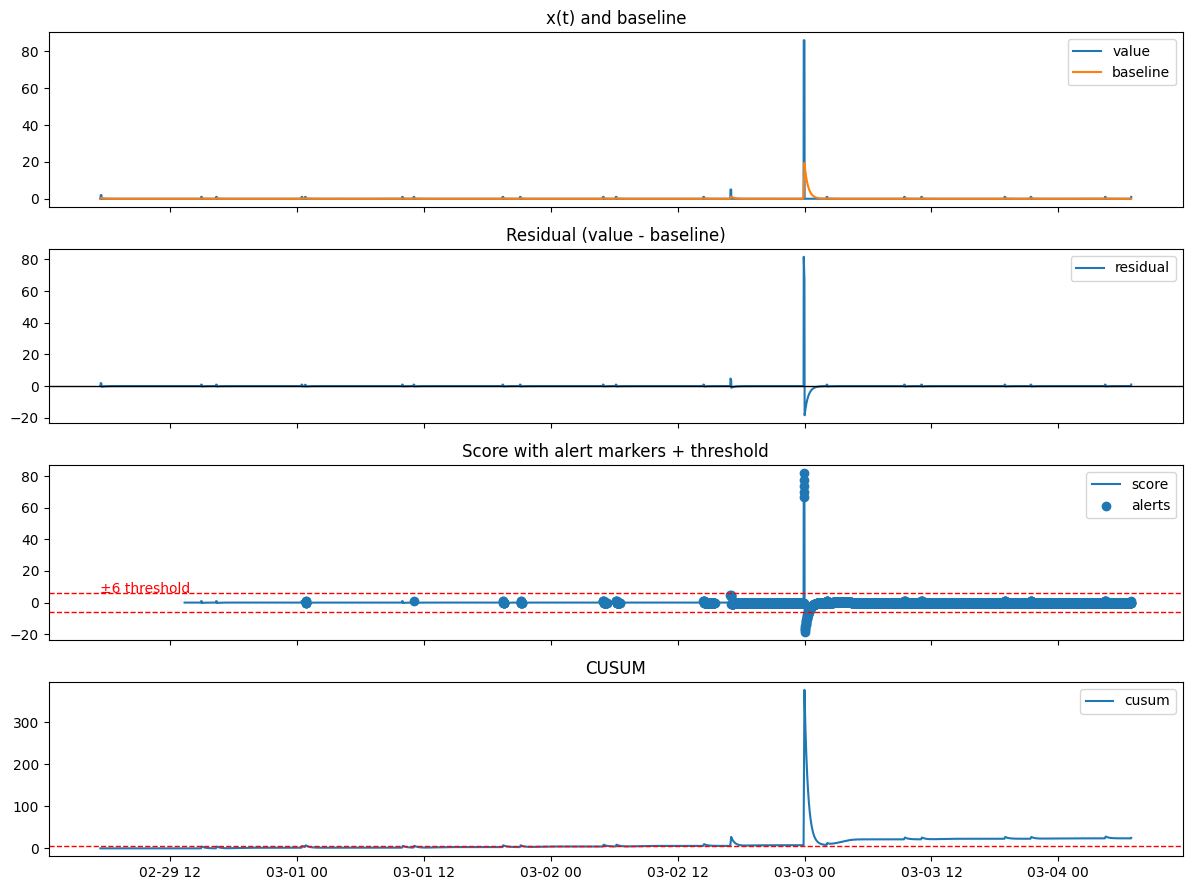

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

"""
How you can run the tool and generate the example files used in this notebook(signal_analysis_example.ipynb):

python signals.py build \
  --input examples/kerberos/dc_security.csv \
  --channels examples/kerberos/channels.yaml \
  --hop 1m \
  --window 5m \
  --out examples/kerberos/dc_4769.parquet

python signals.py detect \
  --input examples/kerberos/dc_4769.csv \
  --alpha 0.05 \
  --score-window 240 \
  --threshold 6 \
  --cusum \
  --out examples/kerberos/analyzed.paraquet \
  --alerts-out examples/kerberos/alerts.paraquet

Where I got the data: 
https://github.com/splunk/attack_data/tree/master/datasets/attack_techniques/T1558.003/unusual_number_of_kerberos_service_tickets_requested

There is a file there called "windows-xml.log", I parsed this using parse_windows_eventlog_xml.py, into an event stream named "dc_security.csv" which is used as input. 

"""

# Load analyzed output (must contain: ts, channel, series_key, value, baseline, residual, score, cusum, is_alert)
df = pd.read_parquet("analyzed.parquet")

# --- pick ONE series to plot ---
# Use the "simple g" pattern: a query + index on ts.
# Change these two lines to point at any channel/series_key you want.
channel = "event_4769_by_src_ip"
series_key = "src_ip=10.0.1.15"
# channel = "event_4769_global"
# series_key = "global"

g = (
    df.query("channel == @channel and series_key == @series_key")
      .assign(ts=lambda d: pd.to_datetime(d["ts"]))
      .set_index("ts")
      .sort_index()
)

threshold = 6  # score threshold used in your CLI example
alerts = g[g["is_alert"] == True]

fig, axs = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

# 1) value + baseline
axs[0].plot(g.index, g["value"], label="value")
axs[0].plot(g.index, g["baseline"], label="baseline")
axs[0].set_title("x(t) and baseline")
axs[0].legend(loc="upper right")

# 2) residual
axs[1].plot(g.index, g["residual"], label="residual")
axs[1].axhline(0, color="black", linewidth=1)
axs[1].set_title("Residual (value - baseline)")
axs[1].legend(loc="upper right")

# 3) score + threshold bars + alert markers
axs[2].plot(g.index, g["score"], label="score")
axs[2].axhline(+threshold, color="red", linestyle="--", linewidth=1)
axs[2].axhline(-threshold, color="red", linestyle="--", linewidth=1)
axs[2].scatter(alerts.index, alerts["score"], label="alerts", marker="o")
axs[2].set_title("Score with alert markers + threshold")
axs[2].text(g.index[0], 6, "±6 threshold", color="red")
axs[2].legend(loc="upper right")

# 4) CUSUM + threshold bar (same threshold by default)
axs[3].plot(g.index, g["cusum"], label="cusum")
axs[3].axhline(threshold, color="red", linestyle="--", linewidth=1)
axs[3].set_title("CUSUM")
axs[3].legend(loc="upper right")

plt.tight_layout()
plt.show()
